# Fitting Spectroscopy with variable spectral resolution

One thing that's come up quite frequently recently is people wanting to fit spectra that have strongly variable resolution as a function of wavelength, in particular data from the JWST NIRSpec prism.

With the help of several people I've now implemented the ability to convolve models for spectroscopic data with an arbitrary spectral resolving power curve supplied by the user. The below is an example of how to include this in a model galaxy, the process for including it in a fit should be identical.

#### This is brand new functionality which is nowhere near as well tested as the rest of the code. If you encounter difficulties or something doesn't appear to be working as expected please let me know.

## Setting up

Let's begin by running setting up a very simple model for a star-forming galaxy at redshift 3.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bagpipes as pipes
from astropy.io import fits


nebular = {}
nebular["logU"] = -2.

constant = {}
constant["massformed"] = 9.
constant["metallicity"] = 0.2
constant["age_min"] = 0.
constant["age_max"] = 0.1

model_comp = {}
model_comp["constant"] = constant
model_comp["nebular"] = nebular
model_comp["t_bc"] = 0.01
model_comp["redshift"] = 3.


Starting dense_basis. Failed to load FSPS, only GP-SFH module will be available.


Now we can specify the spectral resolving power curve using the "R_curve" keyword. Here's one taken from the [JWST documentation](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-instrumentation/nirspec-dispersers-and-filters) for the NIRSpec prism. The model_components entry should contain a 2D array with a column of wavelength values in Angstroms and a column of R values. It should be noted that this file and the others provided in the documentation linked above were derived pre-launch of JWST and come with their own sets of assumptions that potential authors should familarise themselves with.

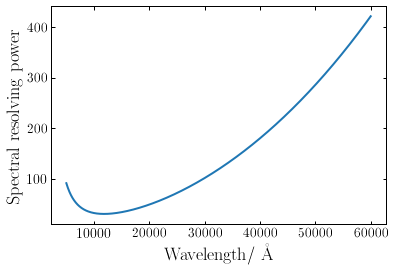

In [2]:
hdul = fits.open("jwst_nirspec_prism_disp.fits")
model_comp["R_curve"] = np.c_[10000*hdul[1].data["WAVELENGTH"], hdul[1].data["R"]]

plt.plot(model_comp["R_curve"][:, 0], model_comp["R_curve"][:, 1])
plt.xlabel("Wavelength/ \AA")
plt.ylabel("Spectral resolving power")
plt.show()

Now we can make the model. We'll use some example wavelength values for spectroscopic data from the NIRSpec prism that come out of the JWST pipeline, which I've pre-saved to a file.

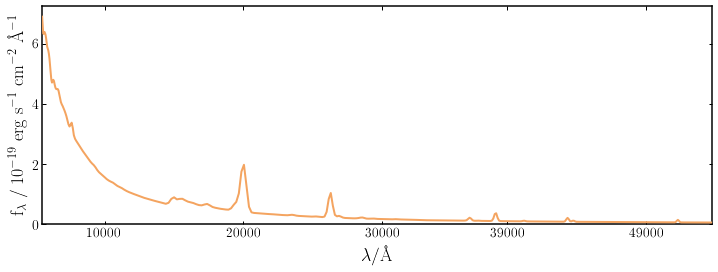

In [3]:
prism_wavs = np.loadtxt("nirspec_prism_pipeline_output_wavs.txt")

model = pipes.model_galaxy(model_comp, spec_wavs=prism_wavs)
fig = model.plot()

We can confirm this is doing what we expect by adjusting the redshift and looking at how the \[OIII\] line changes as the resolution increases towards the red end of the spectrum. You'll see that as redshift increases, the Hbeta line becomes separately resolved, with the two components of \[OIII\] also separately resolved by redshift 9.

Redshift 3.0


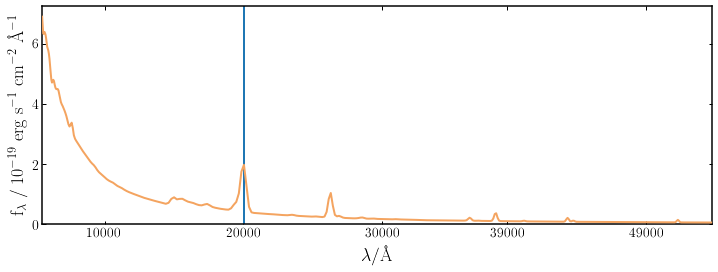

Redshift 5.0


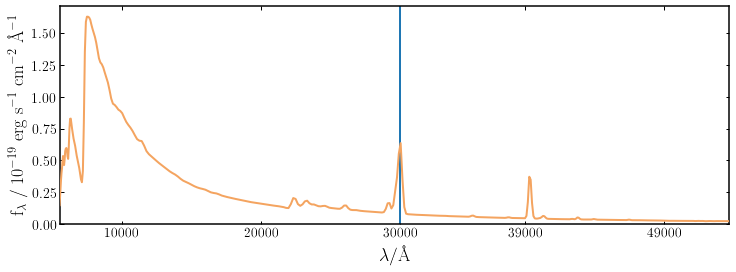

Redshift 7.0


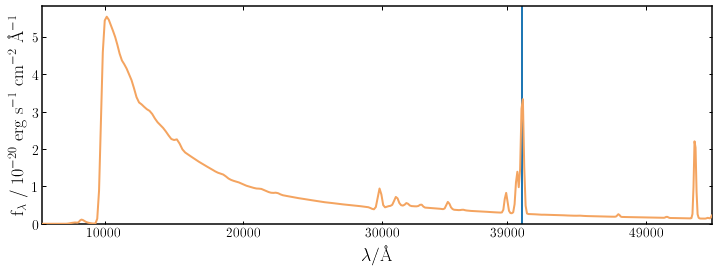

Redshift 9.0


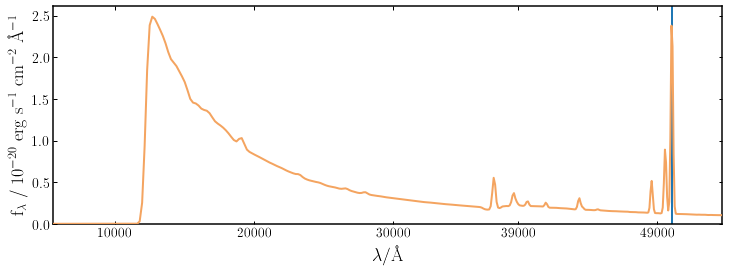

In [4]:
for i in range(4):
    print("Redshift", model_comp["redshift"])
    model = pipes.model_galaxy(model_comp, spec_wavs=prism_wavs)
    fig, ax = model.plot(show=False)
    ax[0].axvline(5007*(1+model_comp["redshift"]))
    fig = plt.show()
    model_comp["redshift"] += 2